In [1]:
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize

import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, HMC
import numpy as np
import torch

/home/user/pyro/env_3_10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Coin Flip - Beta dist

Beta(1+#heads, 1+#tails)

In [2]:
n_trials = [0, 1, 2, 3, 4, 5, 8, 15, 50, 500]
x = np.linspace(0, 1, 100)
data = pyro.sample('coin_toss', pyro.distributions.Bernoulli(0.5), [n_trials[-1]])

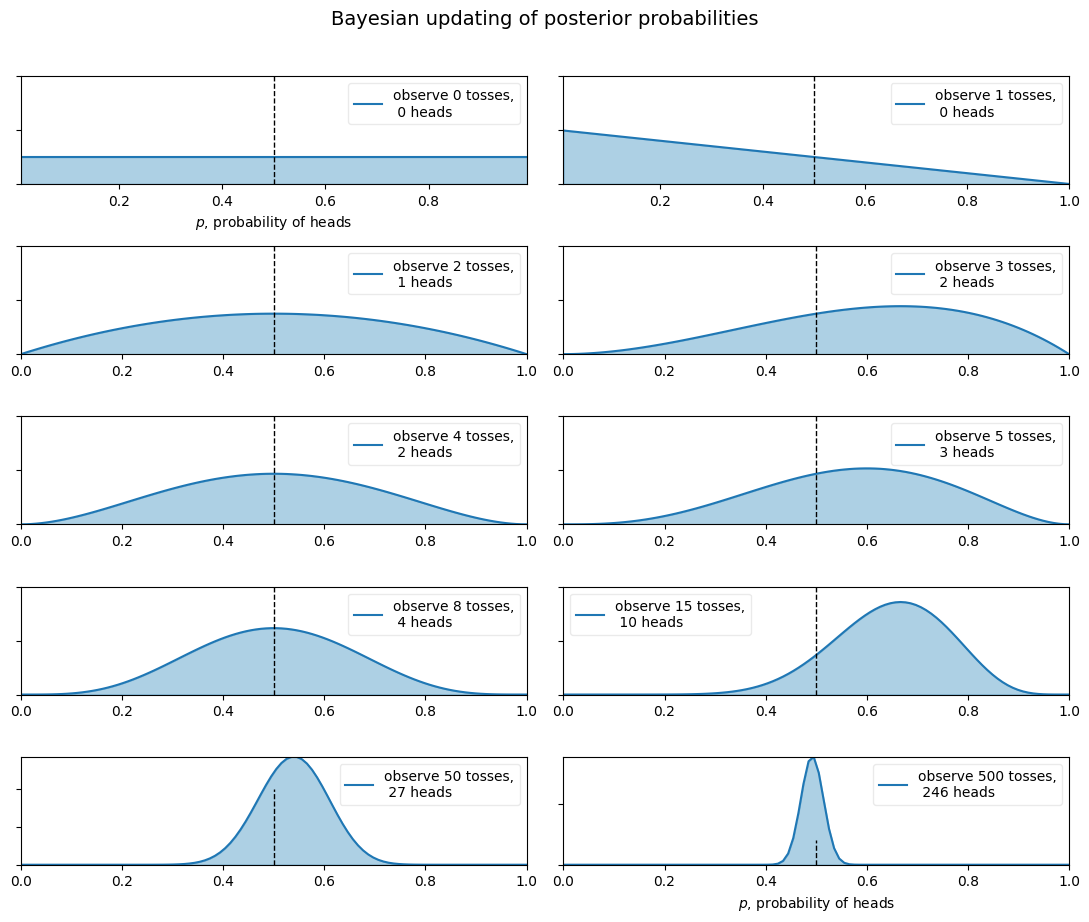

In [3]:
# For the already prepared, I'm using Binomial's conj. prior.
figsize(11, 9)

for k, N in enumerate(n_trials):
    sx = plt.subplot(len(n_trials)//2, 2, k+1)
    plt.xlabel("$p$, probability of heads") \
        if k in [0, len(n_trials)-1] else None
    plt.setp(sx.get_yticklabels(), visible=False)
    heads = data[:N].sum()
    d = dist.Beta(1 + heads, 1 + N - heads)
    y = torch.exp(d.log_prob(torch.tensor(x)))
    plt.plot(x, y, label="observe %d tosses,\n %d heads" % (N, heads))
    plt.fill_between(x, 0, y, color="#348ABD", alpha=0.4)
    plt.vlines(0.5, 0, 4, color="k", linestyles="--", lw=1)

    leg = plt.legend()
    leg.get_frame().set_alpha(0.4)
    plt.autoscale(tight=True)


plt.suptitle("Bayesian updating of posterior probabilities",
             y=1.02,
             fontsize=14)

plt.tight_layout()

User's messages - Poison and Exp dist

#messages = $n(\Delta time)$

Exp - time between messages, $\frac{1}{n(\Delta time)}$ = $\lambda$

Poison - $n(\Delta time)$



Hypothesis: the number of messages changed recently

(0.0, 74.0)

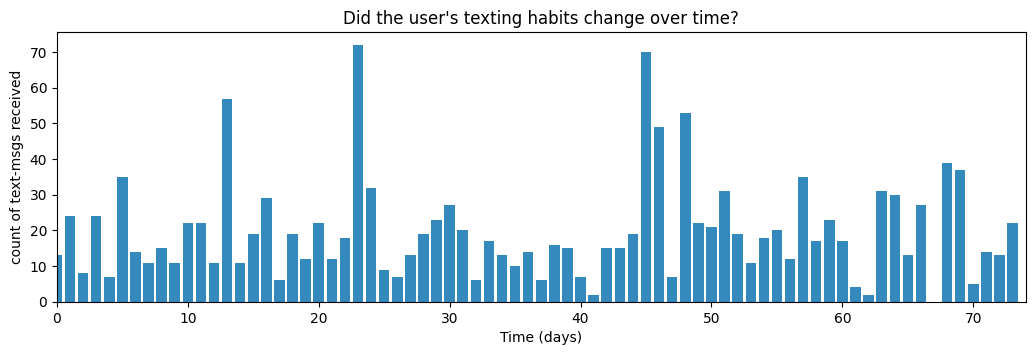

In [4]:
figsize(12.5, 3.5)
count_data = torch.from_numpy(np.loadtxt("data/txtdata.csv"))
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data)

In [5]:
def model(data):
    alpha = 1.0 / data.mean()
    lambda_1 = pyro.sample("lambda_1", dist.Exponential(alpha))
    lambda_2 = pyro.sample("lambda_2", dist.Exponential(alpha))
    
    tau = pyro.sample("tau", dist.Uniform(0, 1))
    lambda1_size = (tau * data.size(0) + 1).long()
    lambda2_size = data.size(0) - lambda1_size
    lambda_ = torch.cat([lambda_1.expand((lambda1_size,)),
                         lambda_2.expand((lambda2_size,))])

    pyro.sample("obs", dist.Poisson(lambda_), obs=data)


In [6]:
kernel = NUTS(model, jit_compile=True, ignore_jit_warnings=True, max_tree_depth=3)
posterior = MCMC(kernel, num_samples=5000, warmup_steps=500)
posterior.run(count_data)

Sample: 100%|██████████| 5500/5500 [00:25, 215.21it/s, step size=1.49e-01, acc. prob=0.861]


In [7]:
hmc_samples = {k: v.detach().cpu().numpy() for k, v in posterior.get_samples().items()}
lambda_1_samples = hmc_samples['lambda_1']
lambda_2_samples = hmc_samples['lambda_2']
tau_samples = (hmc_samples['tau'] * count_data.size(0) + 1).astype(int)

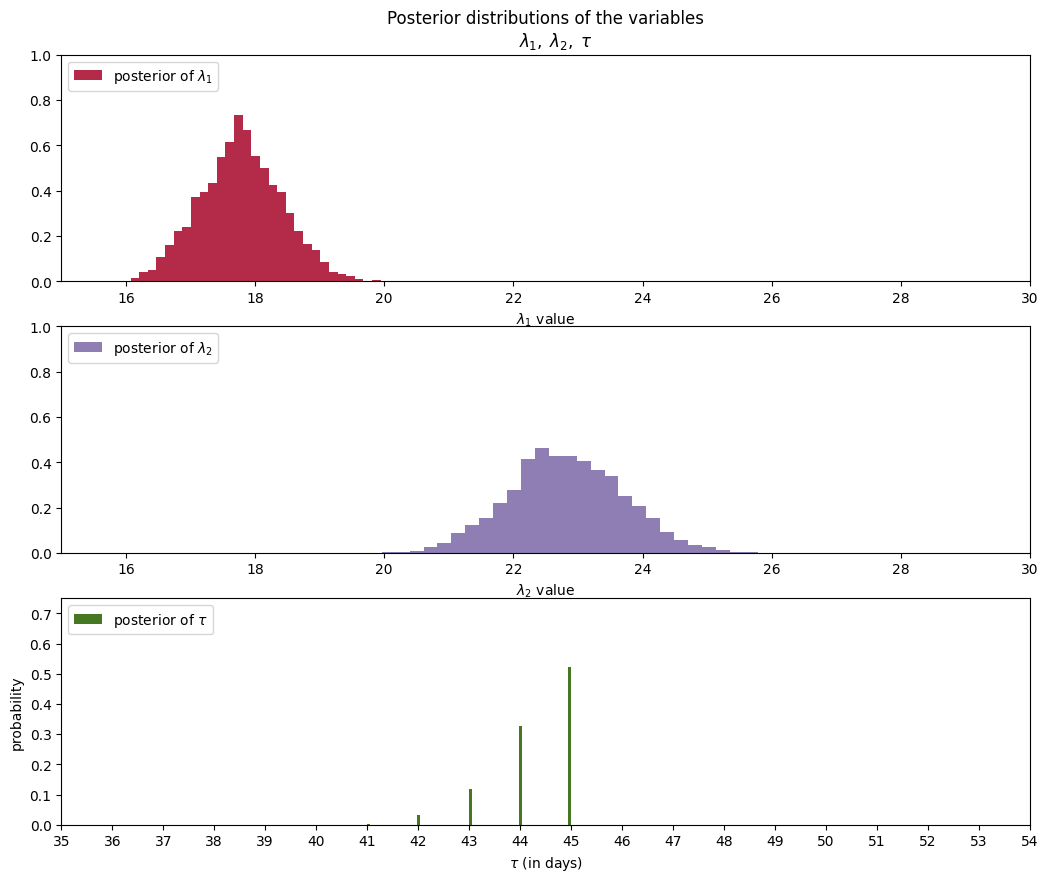

In [8]:
figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

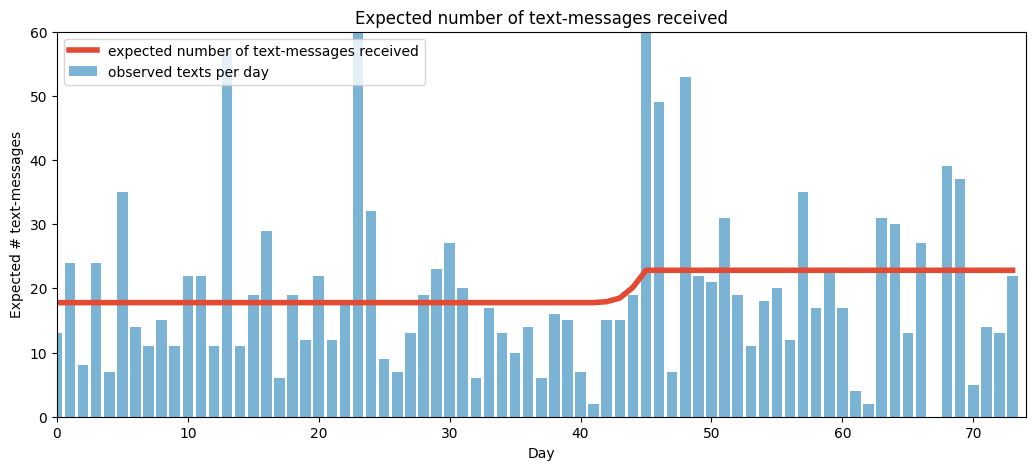

In [9]:
figsize(12.5, 5)

N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    ix = day < tau_samples
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left")


In [10]:
print(lambda_1_samples.mean() / lambda_2_samples.mean())
print((lambda_1_samples / lambda_2_samples).mean())

0.7790686994089795
0.7802002698191615


In [11]:
lambda_1_samples[tau_samples < 45].mean()

17.748817092798504